<h1 style="text-align:center;"><b>Laboratorio 2</b></h1>
<h3 style="text-align:center;">Alina Carías (22539), Daniel Machic (22118), Ariela Mishaan (22052)</h3>

**Github**: https://github.com/ArielaMishaanCohen/LAB2.git  

# Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from imageio.v3 import imread

## Task 1

**Cargar imagen en escala de grises**

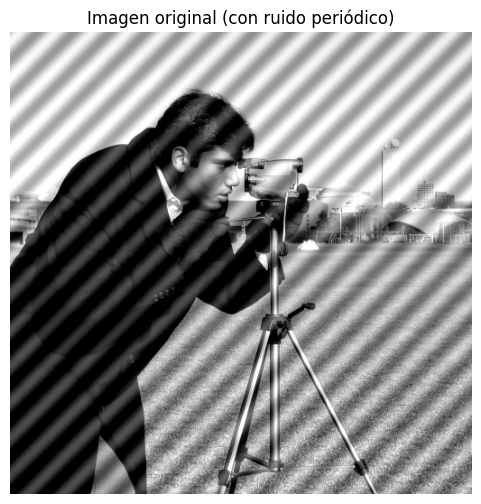

In [2]:
img = imread("periodic_noise.jpg")

if img.ndim == 3:
    img = (0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2])

img = img.astype(np.float32)

plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")
plt.title("Imagen original (con ruido periódico)")
plt.axis("off")
plt.show()


**DFT y Espectro de magnitud**

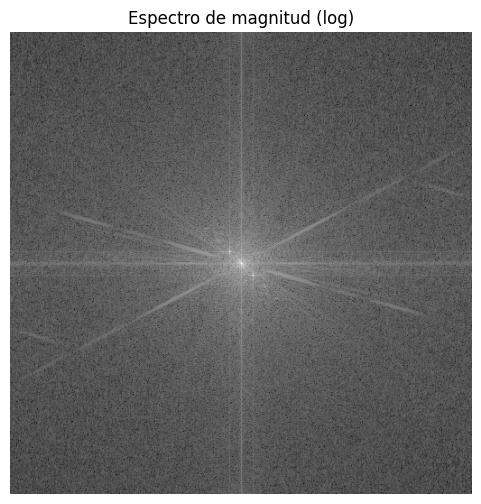

In [3]:
F = np.fft.fft2(img)
Fshift = np.fft.fftshift(F)

magnitude = np.abs(Fshift)
log_spectrum = np.log1p(magnitude)

plt.figure(figsize=(6,6))
plt.imshow(log_spectrum, cmap="gray")
plt.title("Espectro de magnitud (log)")
plt.axis("off")
plt.show()


**Indentificación de picos del ruido**

Picos detectados: [(np.int64(243), np.int64(243)), (np.int64(269), np.int64(269))]


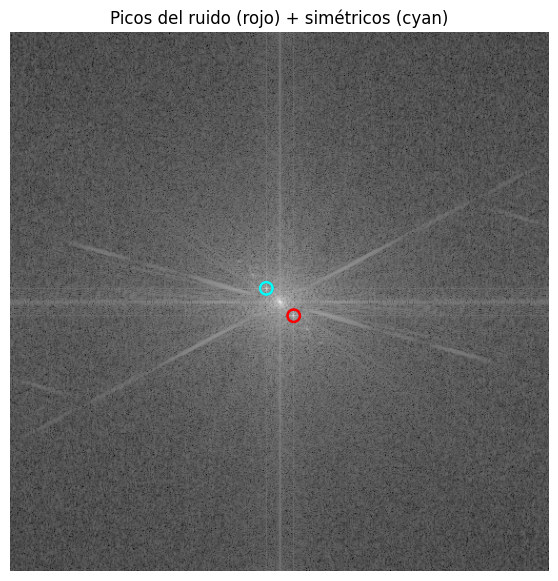

In [ ]:
h, w = log_spectrum.shape
cy, cx = h//2, w//2

# Eliminar el DC
dc_r = 6
Y, X = np.ogrid[:h, :w]
dc_mask = (Y-cy)**2 + (X-cx)**2 <= dc_r**2

spec = log_spectrum.copy()
spec[dc_mask] = 0

# Tomar una cantidad k de picos altos
K = 12
flat = spec.ravel()
idx = np.argpartition(flat, -K)[-K:]
idx = idx[np.argsort(flat[idx])[::-1]]
cands = [np.unravel_index(i, spec.shape) for i in idx]

# Eliminar picos cercanos
min_dist = 12
peaks = []
for (py, px) in cands:
    ok = True
    for (qy, qx) in peaks:
        if (py-qy)**2 + (px-qx)**2 < min_dist**2:
            ok = False
            break
    if ok:
        peaks.append((py, px))

print("Picos detectados:", peaks)

plt.figure(figsize=(7,7))
plt.imshow(log_spectrum, cmap="gray")
plt.title("Picos del ruido (rojo) + simétricos (cyan)")
for (py, px) in peaks:
    plt.scatter([px],[py], s=80, facecolors="none", edgecolors="r", linewidths=2)
    sy, sx = 2*cy - py, 2*cx - px
    plt.scatter([sx],[sy], s=80, facecolors="none", edgecolors="cyan", linewidths=2)
plt.axis("off")
plt.show()


**Máscara notch**

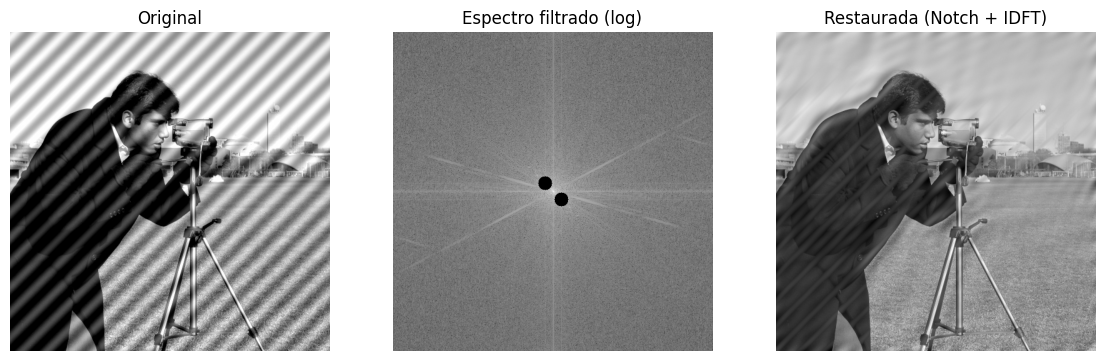

In [ ]:
mask = np.ones((h, w), dtype=np.float32)

notch_r = 11  # Manejo de las lineas horizonatales

def zero_circle(y0, x0, r):
    circle = (Y-y0)**2 + (X-x0)**2 <= r**2
    mask[circle] = 0

for (py, px) in peaks:
    zero_circle(py, px, notch_r)
    sy, sx = 2*cy - py, 2*cx - px
    zero_circle(sy, sx, notch_r)

mask[dc_mask] = 1

F_filt = Fshift * mask
img_back = np.real(np.fft.ifft2(np.fft.ifftshift(F_filt)))

plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(np.log1p(np.abs(F_filt)), cmap="gray")
plt.title("Espectro filtrado (log)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img_back, cmap="gray")
plt.title("Restaurada (Notch + IDFT)")
plt.axis("off")

plt.show()


**Restaurar imagen**

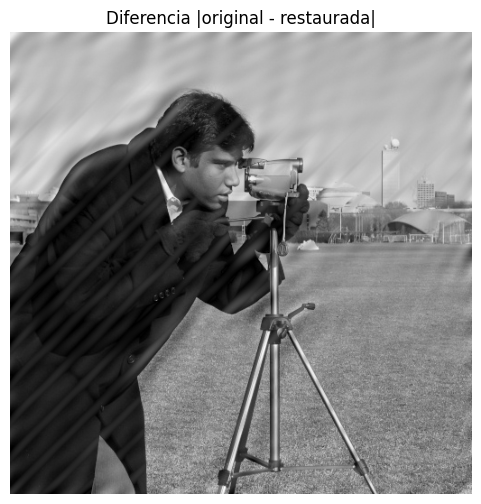

In [24]:
diff = np.abs(img_back)

plt.figure(figsize=(6,6))
plt.imshow(diff, cmap="gray")
plt.title("Diferencia |original - restaurada|")
plt.axis("off")
plt.show()


**Explicación**

Un filtro promedio en el dominio espacial suaviza toda la imagen por igual. Eso reduce las rayas, pero también borra bordes y texturas reales, porque elimina altas frecuencias útiles junto con el ruido. Sin embargo, el ruido periódico se muestra como picos específicos con Fourier. Un notch filter deja anular únicamente frecuencias extrañas y converva el resto de la información, manteniendo detalles nítidos. 

In [7]:
# Fuente: https://www.geeksforgeeks.org/computer-vision/fast-fourier-transform-in-image-processing/ 
# Fuente:https://stackoverflow.com/questions/65483030/notch-reject-filtering-in-python

# Task 2